## Node

In [4]:
class Node:
    def __init__(self, featureIndex=None, threshold=None, left=None, right=None, infoGain=None, value=None):
        self.featureIndex = featureIndex
        self.threshold = threshold
        self.left = left
        self.right = right
        self.infoGain = infoGain
        self.value = value


## Decision Tree Implementation

In [5]:
import numpy as np
import pandas as pd


class DecisionTree:
    def __init__(self, minSamples, maxDepth, class_names=None):
        self.minSamples = minSamples
        self.maxDepth = maxDepth
        self.root = None
        self.class_names = class_names

    def buildTree(self, dataset, currDepth=0):
        X, Y = dataset.iloc[:, :-1], dataset.iloc[:, -1]
        numSamples, numCols = dataset.shape
        numFeatures = numCols - 1

        if numSamples <= self.minSamples or currDepth >= self.maxDepth:
            leafValue = self.calcLeafValue(Y)
            return Node(value=leafValue)

        bestSplit = self.getBestSplit(dataset=dataset, numSamples=numSamples, numFeatures=numFeatures)

        if not bestSplit or bestSplit.get("infoGain", 0) <= 0:
            leafValue = self.calcLeafValue(Y)
            return Node(value=leafValue)

        left_subtree = self.buildTree(bestSplit["left"], currDepth + 1)
        right_subtree = self.buildTree(bestSplit["right"], currDepth + 1)
        return Node(featureIndex=bestSplit["featureIndex"], threshold=bestSplit["threshold"], 
                   left=left_subtree, right=right_subtree, infoGain=bestSplit["infoGain"])

    def getBestSplit(self, dataset, numSamples, numFeatures):
        max_IG = -float("inf")
        bestSplit = {}

        for featureIndex in range(numFeatures):
            featureSamples = dataset.iloc[:, featureIndex]
            uniqueThresholds = np.sort(np.unique(featureSamples))

            if len(uniqueThresholds) <= 1:
                continue

            possibleThresholds = (uniqueThresholds[:-1] + uniqueThresholds[1:]) / 2.0

            for threshold in possibleThresholds:
                leftDataset, rightDataset = self.split(dataset=dataset, featureIndex=featureIndex, threshold=threshold)

                if len(leftDataset) > 0 and len(rightDataset) > 0:
                    datasetTargets = dataset.iloc[:, -1]
                    leftTargets = leftDataset.iloc[:, -1]
                    rightTargets = rightDataset.iloc[:, -1]
                    datasetEntropy = self.entropy(datasetTargets)
                    leftDatasetEntropy = self.entropy(leftTargets)
                    rightDatasetEntropy = self.entropy(rightTargets)
                    IG = self.informationGain(datasetEntropy, leftDatasetEntropy, rightDatasetEntropy, 
                                            datasetTargets, leftTargets, rightTargets)

                    if IG > max_IG:
                        max_IG = IG
                        bestSplit["featureIndex"] = featureIndex
                        bestSplit["threshold"] = threshold
                        bestSplit["left"] = leftDataset
                        bestSplit["right"] = rightDataset
                        bestSplit["infoGain"] = IG

        return bestSplit

    def split(self, dataset, featureIndex, threshold):
        mask = np.array(dataset.iloc[:, featureIndex]) <= threshold
        leftDataset, rightDataset = dataset[mask], dataset[~mask]
        return leftDataset, rightDataset

    def entropy(self, dataset):
        datasetEntropy = 0.0
        numberOfExamples = len(dataset)
        classesLabels = np.unique(dataset)

        for cls in classesLabels:
            p = len(dataset[dataset == cls]) / numberOfExamples
            if p > 0:
                datasetEntropy = datasetEntropy - (p * np.log2(p))

        return datasetEntropy

    def informationGain(self, datasetEntropy, leftDatasetEntropy, rightDatasetEntropy, 
                       datasetTargets, leftTargets, rightTargets):
        l_weight = len(leftTargets) / len(datasetTargets)
        r_weight = len(rightTargets) / len(datasetTargets)
        IG = datasetEntropy - (l_weight * leftDatasetEntropy + r_weight * rightDatasetEntropy)
        return IG

    def calcLeafValue(self, Y):
        classes, counts = np.unique(Y, return_counts=True)
        return classes[np.argmax(counts)]

    def fit(self, X, Y):
        dataset = pd.DataFrame(np.concatenate((X, Y), axis=1))
        self.root = self.buildTree(dataset)

    def predict(self, X):
        predictions = [self.makePrediction(x, self.root) for x in X]
        return np.array(predictions)

    def makePrediction(self, x, tree):
        if tree.value is not None:
            return tree.value

        feature = x[tree.featureIndex]
        if feature <= tree.threshold:
            return self.makePrediction(x, tree.left)
        else:
            return self.makePrediction(x, tree.right)



## Random Forest Implementation

In [6]:

# Custom Random Forest Implementation (FIXED)
from collections import Counter


class RandomForest:
    def __init__(self, n_trees=10, max_features=None, max_depth=None, min_samples_split=2, 
                 class_names=None, random_state=None):
        self.n_trees = n_trees
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.class_names = class_names
        self.trees = []
        self.random_state = random_state

        if random_state is not None:
            np.random.seed(random_state)

    def _bootstrap_sample(self, X, Y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], Y[indices]

    def _get_feature_indices(self, n_features):
        if self.max_features is None:
            return np.arange(n_features)
        else:
            return np.random.choice(n_features, self.max_features, replace=False)

    def fit(self, X, Y):
        self.trees = []
        n_features = X.shape[1]

        for i in range(self.n_trees):
            X_sample, Y_sample = self._bootstrap_sample(X, Y)
            feature_indices = self._get_feature_indices(n_features)

            tree = DecisionTree(
                minSamples=self.min_samples_split,
                maxDepth=self.max_depth,
                class_names=self.class_names
            )

            X_tree = X_sample[:, feature_indices]
            tree.fit(X_tree, Y_sample)
            self.trees.append((tree, feature_indices))

    def predict(self, X):
        tree_preds = []

        for tree, feature_indices in self.trees:
            X_sub = X[:, feature_indices]
            preds = tree.predict(X_sub)
            tree_preds.append(preds)

        tree_preds = np.array(tree_preds)
        y_pred = []

        for i in range(X.shape[0]):
            votes = tree_preds[:, i]
            # Convert to float to ensure consistent type
            votes = votes.astype(float).flatten()
            # Get most common vote
            vote = Counter(votes).most_common(1)[0][0]
            y_pred.append(vote)

        return np.array(y_pred)



## Load Data 
- breast_cancer dataset is used 

In [7]:
from math import floor, sqrt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split

# Load data
data = load_breast_cancer()
X = data.data
Y = data.target.reshape(-1, 1)
feature_names = data.feature_names
class_names = list(data.target_names)

# 70/15/15 split
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, test_size=0.15, random_state=42, stratify=Y
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval, test_size=0.1765, random_state=42, stratify=Y_trainval
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (397, 30), Val: (86, 30), Test: (86, 30)


## Hyperparameter Tuning 

In [8]:
# Hyperparameter grid
best_max_depth = 4
best_min_samples = 2

d = X.shape[1]
grid_T = [5, 10, 30, 50]
grid_max_features = [floor(sqrt(d)), floor(d/2)]

print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

results = []
for T in grid_T:
    for max_feat in grid_max_features:
        rf = RandomForest(
            n_trees=T,
            max_features=max_feat,
            max_depth=best_max_depth,
            min_samples_split=best_min_samples,
            random_state=42,
        )

        rf.fit(X_train, Y_train)
        Y_val_pred = rf.predict(X_val)
        acc = accuracy_score(Y_val, Y_val_pred)

        results.append({
            'T': T,
            'max_features': max_feat,
            'val_accuracy': acc,
        })
        print(f"T={T}, max_features={max_feat}: Val Accuracy={acc:.4f}")


HYPERPARAMETER TUNING
T=5, max_features=5: Val Accuracy=0.9651
T=5, max_features=5: Val Accuracy=0.9651
T=5, max_features=15: Val Accuracy=0.9884
T=5, max_features=15: Val Accuracy=0.9884
T=10, max_features=5: Val Accuracy=0.9419
T=10, max_features=5: Val Accuracy=0.9419
T=10, max_features=15: Val Accuracy=0.9884
T=10, max_features=15: Val Accuracy=0.9884
T=30, max_features=5: Val Accuracy=0.9535
T=30, max_features=5: Val Accuracy=0.9535
T=30, max_features=15: Val Accuracy=0.9767
T=30, max_features=15: Val Accuracy=0.9767
T=50, max_features=5: Val Accuracy=0.9767
T=50, max_features=5: Val Accuracy=0.9767
T=50, max_features=15: Val Accuracy=0.9767
T=50, max_features=15: Val Accuracy=0.9767


## Select best parameters

In [9]:
# Select best hyperparameters
results_df = pd.DataFrame(results)
best_idx = results_df['val_accuracy'].idxmax()
best_params = results_df.iloc[best_idx]

print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
print(f"T (n_trees): {int(best_params['T'])}")
print(f"max_features: {int(best_params['max_features'])}")
print(f"Validation Accuracy: {best_params['val_accuracy']:.4f}")



BEST HYPERPARAMETERS
T (n_trees): 5
max_features: 15
Validation Accuracy: 0.9884


## Hyperparameter Tuning Results

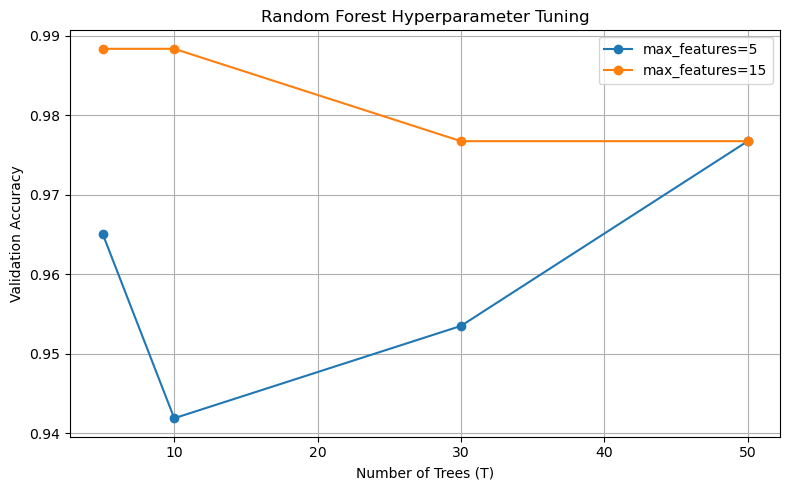

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

if 'results_df' in locals():
    plt.figure(figsize=(8,5))
    for max_feat in results_df['max_features'].unique():
        subset = results_df[results_df['max_features'] == max_feat]
        plt.plot(subset['T'], subset['val_accuracy'], marker='o', label=f'max_features={max_feat}')
    plt.xlabel('Number of Trees (T)')
    plt.ylabel('Validation Accuracy')
    plt.title('Random Forest Hyperparameter Tuning')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Retrain with best params

In [11]:
# Retrain on train+val with best params
rf_final = RandomForest(
    n_trees=int(best_params['T']),
    max_features=int(best_params['max_features']),
    max_depth=best_max_depth,
    min_samples_split=best_min_samples,
    random_state=42,
)

X_trainval_combined = np.vstack([X_train, X_val])
Y_trainval_combined = np.vstack([Y_train, Y_val])

rf_final.fit(X_trainval_combined, Y_trainval_combined)


## Test predict

In [12]:
Y_test_pred = rf_final.predict(X_test)

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)

test_acc = accuracy_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred, average='weighted')
recall = recall_score(Y_test, Y_test_pred, average='weighted')
f1 = f1_score(Y_test, Y_test_pred, average='weighted')

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(Y_test, Y_test_pred, target_names=class_names))

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)
cm = confusion_matrix(Y_test, Y_test_pred)
print(cm)


TEST SET PERFORMANCE

Test Accuracy: 0.9419
Precision (weighted): 0.9425
Recall (weighted): 0.9419
F1-Score (weighted): 0.9420

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   malignant       0.91      0.94      0.92        32
      benign       0.96      0.94      0.95        54

    accuracy                           0.94        86
   macro avg       0.94      0.94      0.94        86
weighted avg       0.94      0.94      0.94        86


CONFUSION MATRIX
[[30  2]
 [ 3 51]]


## Confusion Matrix

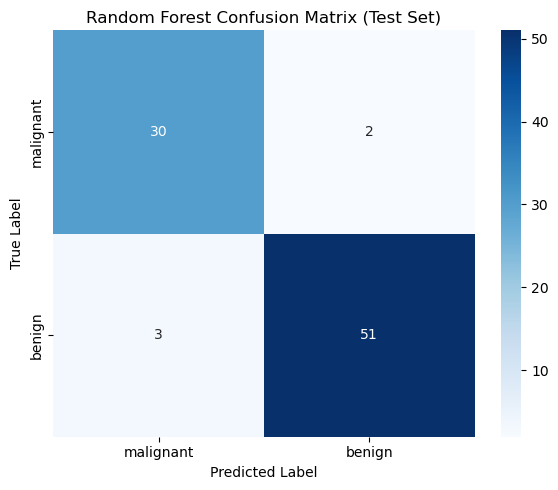

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()


## Feature Importances

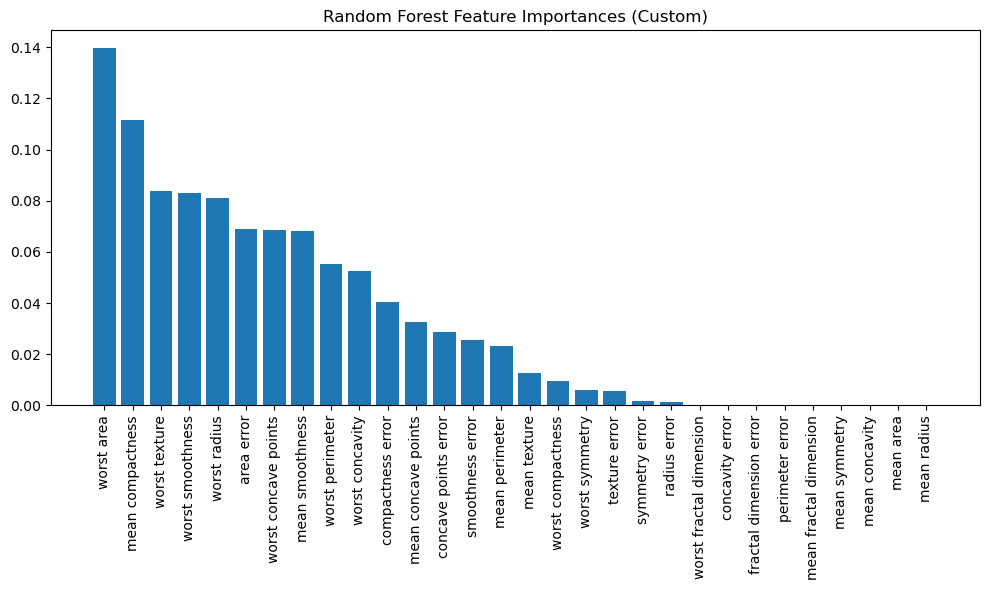

In [14]:
importances = np.zeros(X.shape[1])
for tree, feat_idx in rf_final.trees:
    if hasattr(tree, 'root'):
        def traverse(node, feat_map):
            if node is None or node.value is not None:
                return
            feat_map[feat_idx[node.featureIndex]] += node.infoGain if node.infoGain is not None else 0
            traverse(node.left, feat_map)
            traverse(node.right, feat_map)
        traverse(tree.root, importances)
importances = importances / importances.sum()
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title('Random Forest Feature Importances (Custom)')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


## Visualize Decision Trees from Forest


Visualizing the first 3 trees from the Random Forest:


Tree 1:


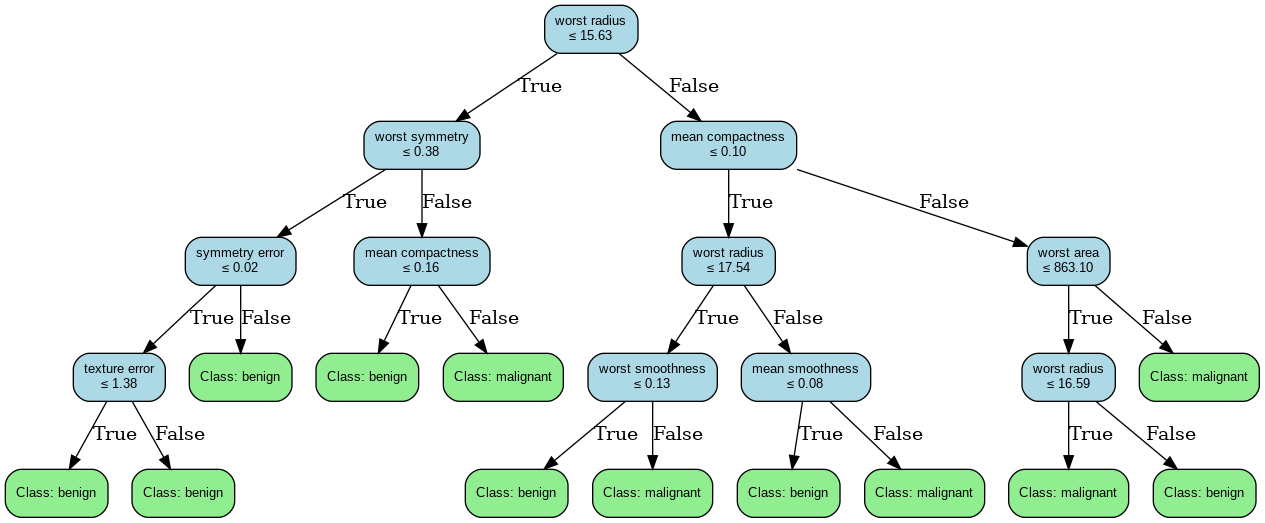


Tree 2:


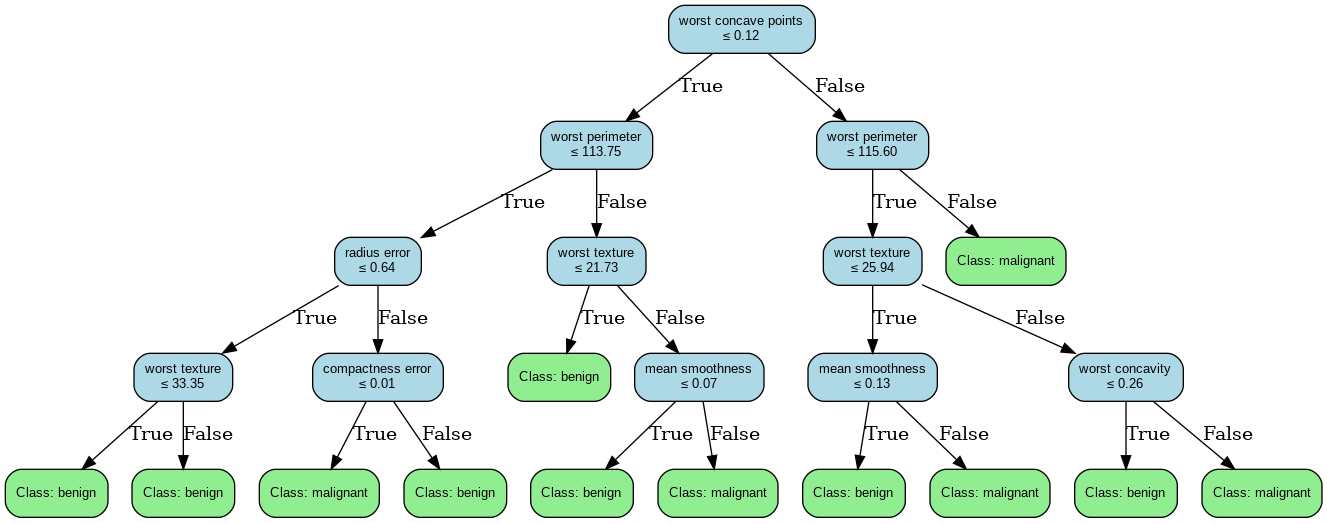


Tree 3:


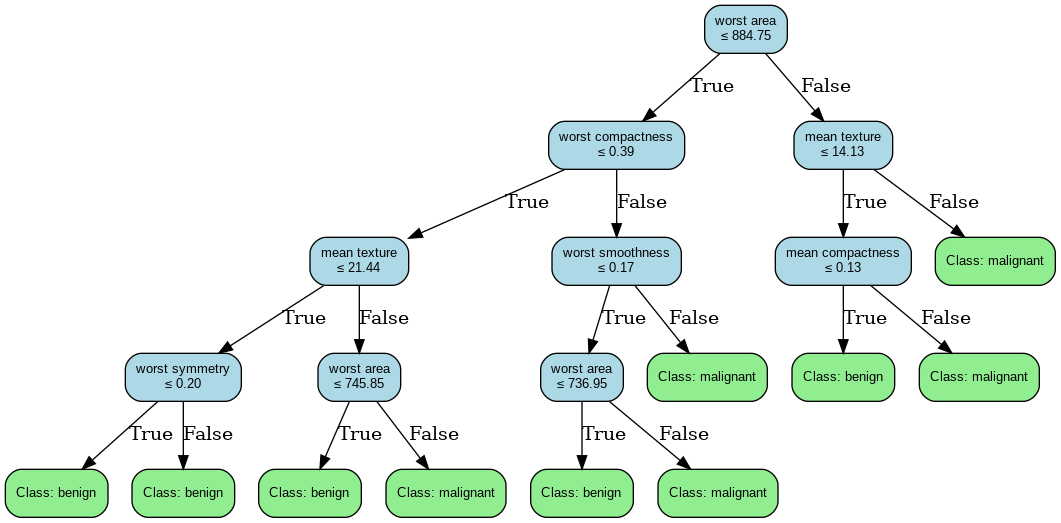


Note: Each tree in the forest uses a bootstrap sample and a random subset of features.
Total trees in forest: 5


In [19]:
from graphviz import Digraph
from IPython.display import Image, display
import os

def visualize_tree_graphviz(tree, feature_indices, feature_names, class_names, tree_num=0, output_dir='/tmp'):
    """
    Visualize a single decision tree using Graphviz and return the graph object
    """
    dot = Digraph(comment=f'Tree {tree_num}', format='png')
    dot.attr(rankdir='TB')
    dot.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue', fontname='Arial', fontsize='10')
    
    node_counter = [0]
    
    def add_nodes(node, parent_id=None, is_left=True):
        if node is None:
            return
        
        node_id = str(node_counter[0])
        node_counter[0] += 1
        
        if node.value is not None:
            # Leaf node
            class_name = class_names[int(node.value)] if class_names else str(node.value)
            label = f"Class: {class_name}"
            dot.node(node_id, label, fillcolor='lightgreen', shape='box')
        else:
            # Decision node
            feature_name = feature_names[feature_indices[node.featureIndex]]
            threshold = node.threshold
            label = f"{feature_name}\n≤ {threshold:.2f}"
            dot.node(node_id, label, fillcolor='lightblue')
        
        if parent_id is not None:
            edge_label = "True" if is_left else "False"
            dot.edge(parent_id, node_id, label=edge_label)
        
        if node.left is not None:
            add_nodes(node.left, node_id, is_left=True)
        if node.right is not None:
            add_nodes(node.right, node_id, is_left=False)
    
    add_nodes(tree.root)
    return dot

# Visualize first few trees
if 'rf_final' not in locals():
    print("Error: rf_final is not defined yet.")
    print("Please run the earlier cells first, especially the 'Retrain with best params' cell.")
else:
    num_trees_to_show = min(3, len(rf_final.trees))
    print(f"\nVisualizing the first {num_trees_to_show} trees from the Random Forest:\n")

    for i in range(num_trees_to_show):
        tree, feature_indices = rf_final.trees[i]
        dot = visualize_tree_graphviz(tree, feature_indices, feature_names, class_names, tree_num=i+1)
        
        # Render and display the tree
        filepath = dot.render(f'/tmp/tree_{i}', cleanup=True)
        print(f"\nTree {i+1}:")
        display(Image(filename=filepath))
    
    print(f"\nNote: Each tree in the forest uses a bootstrap sample and a random subset of features.")
    print(f"Total trees in forest: {len(rf_final.trees)}")


## Random Forest Voting Mechanism (Combined Trees)

Random Forest Voting Mechanism


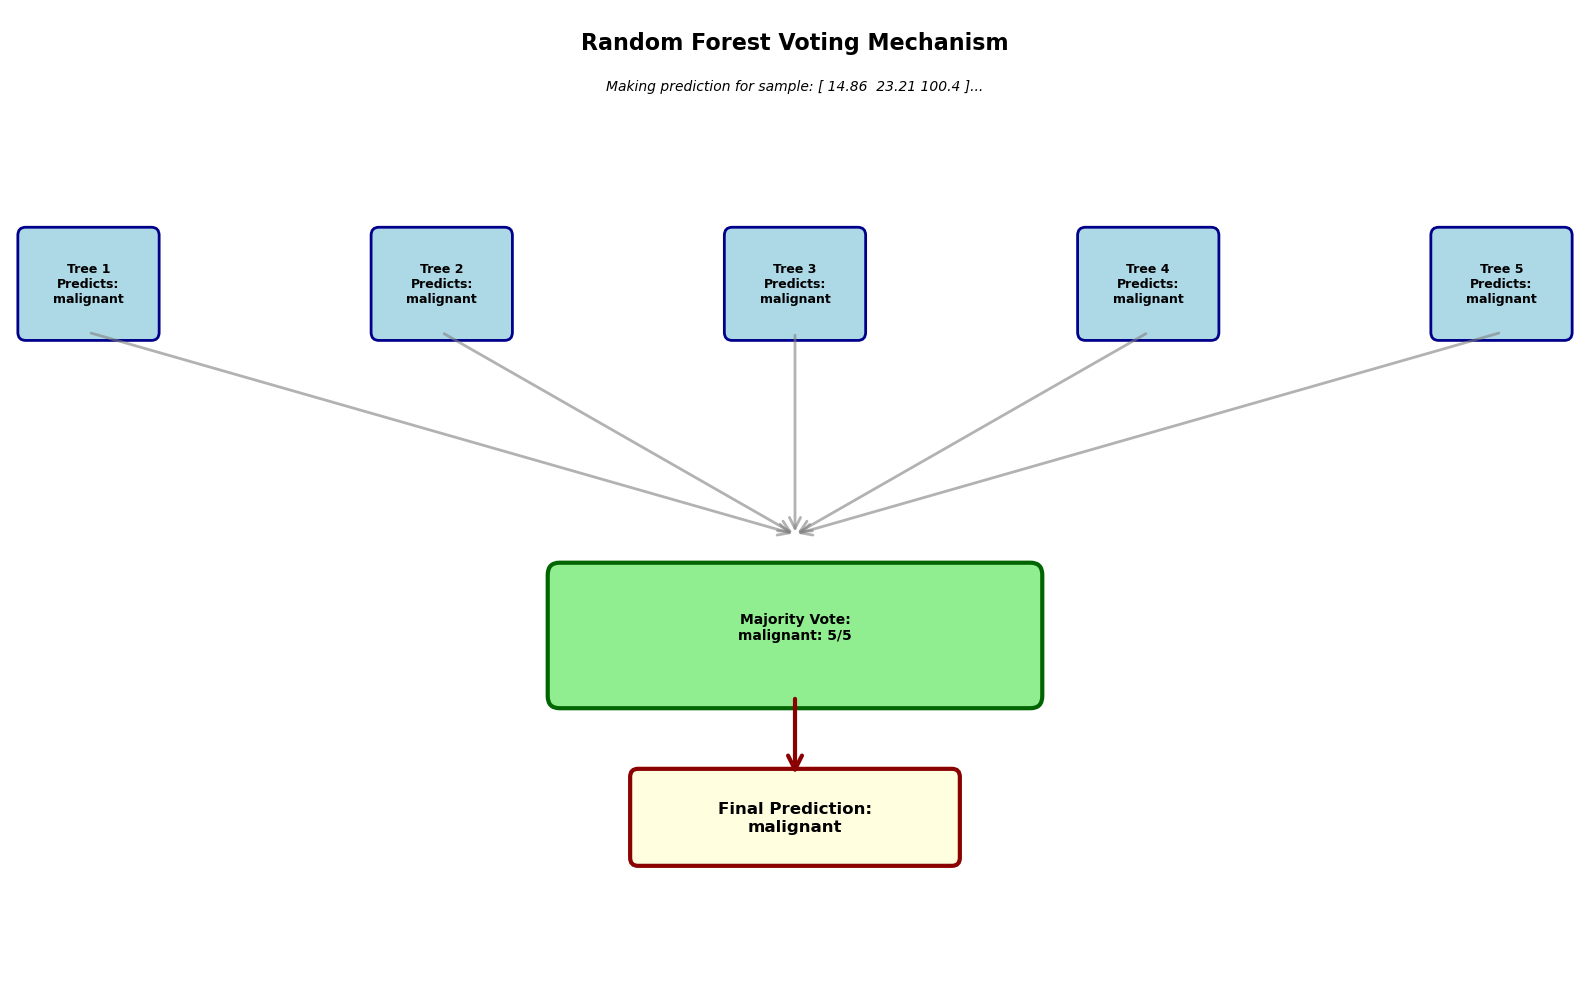


Forest Prediction Breakdown:
Number of trees shown: 5
Individual tree predictions: [np.str_('malignant'), np.str_('malignant'), np.str_('malignant'), np.str_('malignant'), np.str_('malignant')]
Vote counts: {0: 5}
Final prediction: malignant


In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

def visualize_forest_voting(rf_forest, X_sample, y_pred, class_names, feature_names, num_trees=5):
    """
    Visualize how the Random Forest combines predictions from multiple trees
    Shows a sample prediction flow through the forest
    """
    # Use first sample from X_sample
    sample = X_sample[0:1]
    
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 12)
    ax.axis('off')
    
    # Title
    ax.text(10, 11.5, 'Random Forest Voting Mechanism', 
            fontsize=16, fontweight='bold', ha='center')
    ax.text(10, 11, f'Making prediction for sample: {sample[0][:3]}...', 
            fontsize=10, ha='center', style='italic')
    
    # Draw individual tree predictions
    num_to_show = min(num_trees, len(rf_forest.trees))
    tree_x_positions = np.linspace(1, 19, num_to_show)
    predictions = []
    
    for idx, (tree, feature_indices) in enumerate(rf_forest.trees[:num_to_show]):
        x_pos = tree_x_positions[idx]
        
        # Get prediction from this tree
        X_sub = sample[:, feature_indices]
        tree_pred = tree.predict(X_sub)[0]
        predictions.append(tree_pred)
        
        class_name = class_names[int(tree_pred)] if class_names else str(int(tree_pred))
        
        # Draw tree box
        tree_box = FancyBboxPatch((x_pos-0.8, 8), 1.6, 1.2,
                                  boxstyle="round,pad=0.1", 
                                  edgecolor='darkblue', facecolor='lightblue', 
                                  linewidth=2)
        ax.add_patch(tree_box)
        ax.text(x_pos, 8.6, f'Tree {idx+1}\nPredicts:\n{class_name}', 
                ha='center', va='center', fontsize=9, fontweight='bold')
        
        # Draw arrow to voting area
        arrow = FancyArrowPatch((x_pos, 8), (10, 5.5),
                               arrowstyle='->', mutation_scale=20, 
                               linewidth=2, color='gray', alpha=0.6)
        ax.add_patch(arrow)
    
    # Voting/aggregation box
    vote_box = FancyBboxPatch((7, 3.5), 6, 1.5,
                             boxstyle="round,pad=0.15", 
                             edgecolor='darkgreen', facecolor='lightgreen', 
                             linewidth=3)
    ax.add_patch(vote_box)
    
    # Count votes
    from collections import Counter
    votes = Counter([int(p) for p in predictions])
    vote_text = "Majority Vote:\n"
    for class_idx, count in sorted(votes.items()):
        class_name = class_names[class_idx] if class_names else str(class_idx)
        vote_text += f"{class_name}: {count}/{num_to_show}\n"
    
    ax.text(10, 4.25, vote_text, ha='center', va='center', 
            fontsize=10, fontweight='bold')
    
    # Final prediction
    final_pred_class = class_names[int(y_pred[0])] if class_names else str(int(y_pred[0]))
    final_box = FancyBboxPatch((8, 1.5), 4, 1,
                              boxstyle="round,pad=0.1", 
                              edgecolor='darkred', facecolor='lightyellow', 
                              linewidth=3)
    ax.add_patch(final_box)
    ax.text(10, 2, f'Final Prediction:\n{final_pred_class}', 
            ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Arrow from voting to final
    arrow = FancyArrowPatch((10, 3.5), (10, 2.5),
                           arrowstyle='->', mutation_scale=25, 
                           linewidth=3, color='darkred')
    ax.add_patch(arrow)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nForest Prediction Breakdown:")
    print(f"Number of trees shown: {num_to_show}")
    print(f"Individual tree predictions: {[class_names[int(p)] if class_names else str(int(p)) for p in predictions]}")
    print(f"Vote counts: {dict(votes)}")
    print(f"Final prediction: {final_pred_class}")

# Visualize the voting mechanism
if 'rf_final' not in locals():
    print("Error: rf_final is not defined yet.")
else:
    print("Random Forest Voting Mechanism")
    print("=" * 60)
    
    # Get a test sample and its prediction
    X_sample = X_test[:1]  # First test sample
    y_sample_pred = rf_final.predict(X_sample)
    
    visualize_forest_voting(rf_final, X_sample, y_sample_pred, 
                           class_names, feature_names, num_trees=5)


## Tree Prediction Diversity Analysis

In [23]:
import pandas as pd
from collections import Counter

# Analyze tree predictions across test set to see diversity
print("=" * 80)
print("TREE PREDICTION DIVERSITY ANALYSIS")
print("=" * 80)

# Get predictions from all trees on first 10 test samples
num_samples_to_check = 10
all_tree_predictions = []

for tree, feature_indices in rf_final.trees:
    X_sub = X_test[:num_samples_to_check, feature_indices]
    preds = tree.predict(X_sub)
    all_tree_predictions.append(preds)

all_tree_predictions = np.array(all_tree_predictions)

# Create a summary table
print(f"\nIndividual Tree Predictions on first {num_samples_to_check} test samples:")
print(f"(1 = malignant, 0 = benign)\n")

pred_df = pd.DataFrame(all_tree_predictions.T, columns=[f'Tree {i+1}' for i in range(len(rf_final.trees))])
pred_df['True Label'] = Y_test[:num_samples_to_check].flatten()
pred_df['Forest Prediction'] = rf_final.predict(X_test[:num_samples_to_check])
print(pred_df.to_string())

# Calculate diversity metrics
print("\n" + "=" * 80)
print("DIVERSITY METRICS")
print("=" * 80)

# Count how many samples have disagreement among trees
disagreement_count = 0
for i in range(len(X_test)):
    tree_preds = []
    for tree, feature_indices in rf_final.trees:
        X_sub = X_test[i:i+1, feature_indices]
        pred = tree.predict(X_sub)[0]
        tree_preds.append(pred)
    
    # Check if all predictions are the same
    if len(set(tree_preds)) > 1:
        disagreement_count += 1

print(f"Total test samples: {len(X_test)}")
print(f"Samples where trees AGREE: {len(X_test) - disagreement_count}")
print(f"Samples where trees DISAGREE: {disagreement_count}")
print(f"Percentage of agreement: {((len(X_test) - disagreement_count) / len(X_test) * 100):.2f}%")
print(f"Percentage of disagreement: {(disagreement_count / len(X_test) * 100):.2f}%")

# Show an example of disagreement if it exists
if disagreement_count > 0:
    print("\n" + "=" * 80)
    print("EXAMPLE: Sample where trees DISAGREE")
    print("=" * 80)
    
    for i in range(len(X_test)):
        tree_preds = []
        for tree, feature_indices in rf_final.trees:
            X_sub = X_test[i:i+1, feature_indices]
            pred = tree.predict(X_sub)[0]
            tree_preds.append(pred)
        
        if len(set(tree_preds)) > 1:
            print(f"\nTest Sample {i+1}:")
            print(f"Tree predictions: {tree_preds}")
            votes = Counter(tree_preds)
            print(f"Vote counts: {dict(votes)}")
            final_pred = rf_final.predict(X_test[i:i+1])[0]
            print(f"Final prediction (majority vote): {int(final_pred)}")
            print(f"True label: {int(Y_test[i])}")
            break
else:
    print("\n⚠️  WARNING: All trees agree on ALL test samples!")
    print("This suggests the trees may not be diverse enough.")


TREE PREDICTION DIVERSITY ANALYSIS

Individual Tree Predictions on first 10 test samples:
(1 = malignant, 0 = benign)

   Tree 1  Tree 2  Tree 3  Tree 4  Tree 5  True Label  Forest Prediction
0     0.0     0.0     0.0     0.0     0.0           0                0.0
1     0.0     0.0     0.0     0.0     0.0           0                0.0
2     0.0     0.0     0.0     0.0     0.0           0                0.0
3     1.0     1.0     1.0     1.0     0.0           1                1.0
4     0.0     0.0     0.0     0.0     0.0           0                0.0
5     1.0     1.0     1.0     1.0     1.0           1                1.0
6     1.0     1.0     1.0     1.0     1.0           1                1.0
7     0.0     0.0     0.0     0.0     0.0           0                0.0
8     0.0     0.0     0.0     0.0     0.0           0                0.0
9     0.0     1.0     1.0     1.0     1.0           1                1.0

DIVERSITY METRICS
Total test samples: 86
Samples where trees AGREE: 75
Sample

/tmp/ipykernel_275644/745073652.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"True label: {int(Y_test[i])}")


## Training vs Validation Accuracy

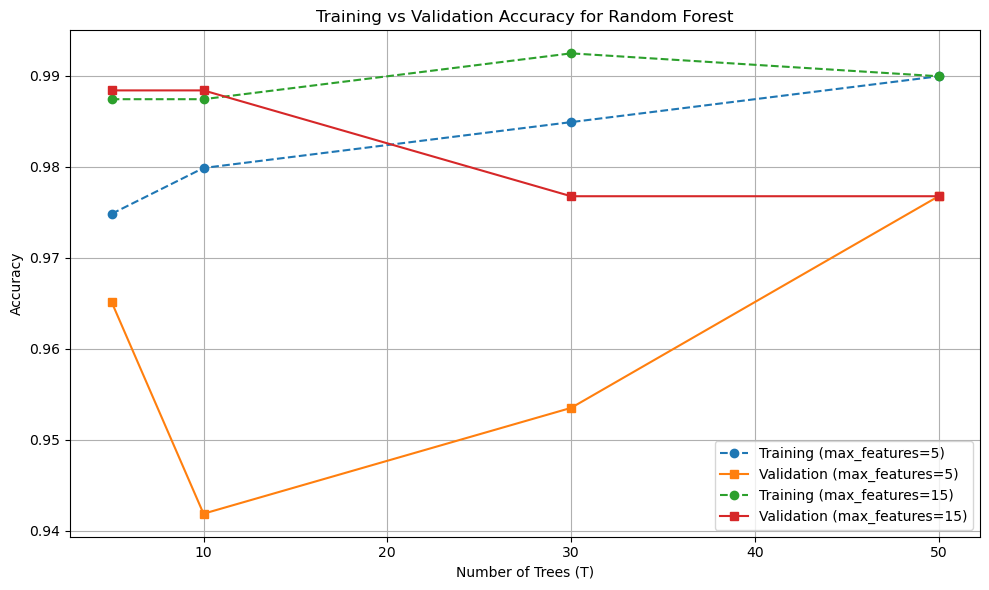

In [ ]:
train_accuracies = []
val_accuracies = []
T_values = []
max_features_values = []

for T in grid_T:
    for max_feat in grid_max_features:
        rf = RandomForest(
            n_trees=T,
            max_features=max_feat,
            max_depth=best_max_depth,
            min_samples_split=best_min_samples,
            random_state=42
        )
        rf.fit(X_train, Y_train)
        Y_train_pred = rf.predict(X_train)
        Y_val_pred = rf.predict(X_val)
        train_acc = accuracy_score(Y_train, Y_train_pred)
        val_acc = accuracy_score(Y_val, Y_val_pred)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        T_values.append(T)
        max_features_values.append(max_feat)

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))
for max_feat in set(max_features_values):
    idxs = [i for i, mf in enumerate(max_features_values) if mf == max_feat]
    plt.plot(np.array(T_values)[idxs], np.array(train_accuracies)[idxs], marker='o', linestyle='--', label=f'Training (max_features={max_feat})')
    plt.plot(np.array(T_values)[idxs], np.array(val_accuracies)[idxs], marker='s', linestyle='-', label=f'Validation (max_features={max_feat})')
plt.xlabel('Number of Trees (T)')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy for Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()